In [1]:
 #Import All Libraries Here
import pandas as pd
from sklearn.metrics import accuracy_score ,  roc_curve, auc , classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
import xgboost as xgb 
import statistics
from scipy.fftpack import fft, ifft


from imblearn.over_sampling import SMOTE 

In [2]:
# Record Constants
INPUT_TRAIN_IN = "../../data/train_in.csv"
INPUT_TRAIN_OUT = "../../data/train_out.csv"  
INPUT_TEST_IN = "../../data/test_in.csv"
INPUT_TEST_OUT = "../../data/test_out.csv"

TARGET_MODEL_PATH = '../../webapp/model_files'

WINDOW_SIZE =  25 # Final RNA Sequence will be 101 Length 
MAX_LENGTH = (WINDOW_SIZE * 2)+1
ENCODING_METHOD = 1 # 1 - Non Furiour Transformation , 2  -  Fourier Transformation 

In [17]:
#Read X Varaibles and Y Varaibles

x_train_raw =  pd.read_csv(INPUT_TRAIN_IN, header=None , skiprows=1 )
y_train_raw =  pd.read_csv(INPUT_TRAIN_OUT, header=None , skiprows=1 )

x_test_raw =  pd.read_csv(INPUT_TEST_IN, header=None , skiprows=1)
y_test_raw =  pd.read_csv(INPUT_TEST_OUT, header=None , skiprows=1)

In [18]:
# Apply ANF Encoding on Input Features
def apply_accumulated_nucle_frequency(seq):
    mapping = []
    A = 0
    C = 0
    T = 0
    G = 0
    for i, v in seq.items():
        if v == 'A':
            A += 1
            mapping.append(A / (i + 1))
        elif v == 'C':
            C += 1
            mapping.append(C / (i + 1))
        elif v == 'T' or v == 'U':
            T += 1
            mapping.append(T / (i + 1))
        else:
            G += 1
            mapping.append(G / (i + 1))
    padding = (MAX_LENGTH - len(mapping))
    mapping = np.pad(mapping, (0, padding), 'constant')
    return mapping

In [19]:
# Encode X Features Based on Middle Index
def encode_x(x_train_raw):
    middle_index = (x_train_raw.shape[1] // 2) + 1
    truncated_df = x_train_raw.iloc[:, middle_index - WINDOW_SIZE - 1: middle_index + WINDOW_SIZE]
    result = truncated_df.apply(apply_accumulated_nucle_frequency, axis=1)
    return result 

x_train_encoded = encode_x(x_train_raw)

### Encode Each Y category to 0 to 12 classes.

In [20]:
#Decode Y to its Original Form . Additional Class - NonMoD added for Non Modified RNA Sequence 
RMs = ['hAm','hCm','hGm','hTm','hm1A','hm5C','hm5U','hm6A','hm6Am','hm7G','hPsi','Atol','NonMoD']
RMEncoding = [0,1,2,3,4,5,6,7,8,9,10,11,12]

def decode_y(row):   
    decoded = ''
    for index , n in enumerate(row.tolist()) :
        if n == 1 :
            decoded = RMEncoding[index]
    
    if decoded == '':
        return 12
    
    return decoded 

y_train_original =  y_train_raw.apply(decode_y , axis=1)
y_train_original.value_counts()

12    152208
7      64978
11     52418
4      16141
6       3496
5       3007
10      2937
8       2247
3       2053
1       1678
0       1391
2       1271
9        836
dtype: int64

### Re-Sample Data Using Smote

In [21]:
#Code Reference : https://github.com/dmlc/xgboost/blob/master/demo/multiclass_classification/train.py
x_train= x_train_encoded.tolist()
y_train = y_train_original 

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_resample(x_train, y_train)


print(y_res.value_counts())

0     152208
12    152208
8     152208
1     152208
2     152208
3     152208
4     152208
7     152208
5     152208
6     152208
9     152208
10    152208
11    152208
dtype: int64


### Train using XGBoost 

In [22]:

xg_train = xgb.DMatrix(x_res, label=y_res)

# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 6
param['nthread'] = 4
param['num_class'] = 13


num_round = 5
bst = xgb.train(param, xg_train, num_round)


### Calculate Accuracy

In [23]:
y_test=  y_test_raw.apply(decode_y , axis=1)

x_test = encode_x(x_test_raw).tolist()
xg_test = xgb.DMatrix(x_test, label=y_test)

#y_test = encode_y(y_test_raw).tolist()

y_pred = bst.predict(xg_test)

print(y_pred)

# Calculate the accuracy score of the xgboost regression model
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy of XGBoost  model: {:.2f}".format(accuracy))

[12. 12. 12. ...  7. 12.  7.]
Accuracy of XGBoost  model: 0.45


Accuracy of XGBoost  model: 0.45


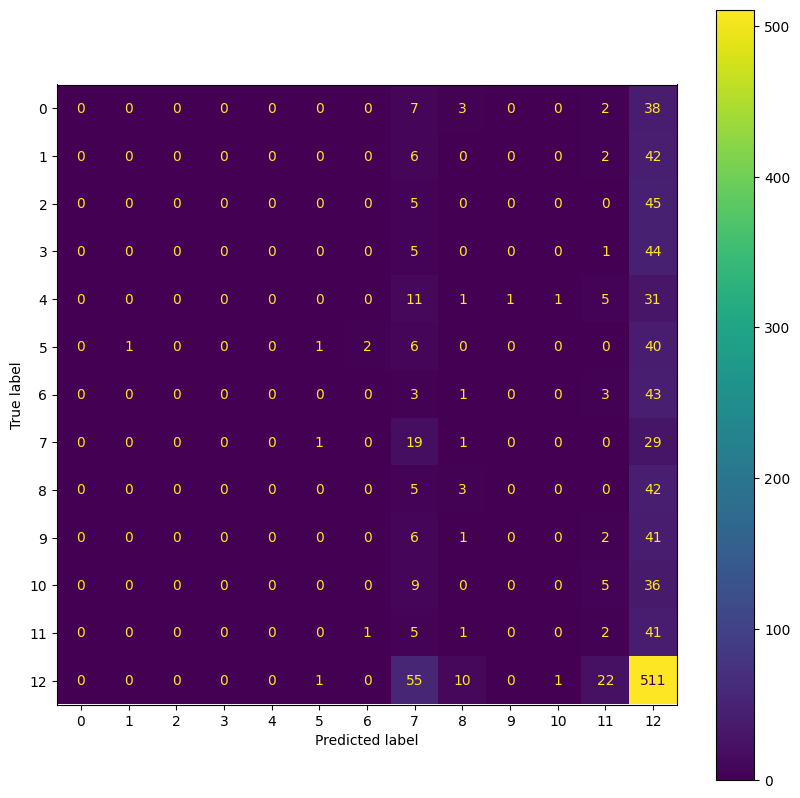

In [24]:
# Plot confusion matrix 
cm = confusion_matrix(y_test, y_pred, labels=np.array(RMEncoding))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=np.array(RMEncoding))

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

print("Accuracy of XGBoost  model: {:.2f}".format(accuracy))

## Save Model 

In [ ]:
import pickle

TARGET_MODEL_PATH += '/model.bin'

##dump the model into a file
with open(TARGET_MODEL_PATH, 'wb') as f_out:
    pickle.dump(bst, f_out) # write final_model in .bin file
    f_out.close()  # close the file 
    print("Exported Model Successfully")  

#  ---------------------- Further Feature Extraction with ANF Fourier Transform -----------------------------------

In [25]:
def feature_extraction(features, spectrum, spectrumTwo):
    average = sum(spectrum) / len(spectrum)
    features.append(average)
    ###################################
    median = np.median(spectrum)
    features.append(median)
    ###################################
    maximum = np.max(spectrum)
    features.append(maximum)
    ###################################
    minimum = np.min(spectrum)
    features.append(minimum)
    ###################################
    peak = (len(spectrum) / 3) / (average)
    features.append(peak)
    ###################################
    peak_two = (len(spectrumTwo) / 3) / (np.mean(spectrumTwo))
    features.append(peak_two)
    ###################################
    standard_deviation = np.std(spectrum)  # standard deviation
    features.append(standard_deviation)
    ###################################
    standard_deviation_pop = statistics.stdev(spectrum)  # population sample standard deviation
    features.append(standard_deviation_pop)
    ###################################
    percentile15 = np.percentile(spectrum, 15)
    features.append(percentile15)
    ###################################
    percentile25 = np.percentile(spectrum, 25)
    features.append(percentile25)
    ###################################
    percentile50 = np.percentile(spectrum, 50)
    features.append(percentile50)
    ###################################
    percentile75 = np.percentile(spectrum, 75)
    features.append(percentile75)
    ###################################
    amplitude = maximum - minimum
    features.append(amplitude)
    ###################################
    # mode = statistics.mode(spectrum)
    ###################################
    variance = statistics.variance(spectrum)
    features.append(variance)
    ###################################
    interquartile_range = np.percentile(spectrum, 75) - np.percentile(spectrum, 25)
    features.append(interquartile_range)
    ###################################
    semi_interquartile_range = (np.percentile(spectrum, 75) - np.percentile(spectrum, 25)) / 2
    features.append(semi_interquartile_range)
    ###################################
    coefficient_of_variation = standard_deviation / average
    features.append(coefficient_of_variation)
    ###################################
    skewness = (3 * (average - median)) / standard_deviation
    features.append(skewness)
    ###################################
    kurtosis = (np.percentile(spectrum, 75) - np.percentile(spectrum, 25)) / (
            2 * (np.percentile(spectrum, 90) - np.percentile(spectrum, 10)))
    features.append(kurtosis)
    ###################################
    return

def accumulated_nucle_frequency_fourier(seq):
    mapping = []
    spectrumTwo = []
    spectrum = []
    features = []
    A = 0
    C = 0
    T = 0
    G = 0
    
    for i , v in seq.items():
        if v == 'A':
            A += 1
            mapping.append(A / (i + 1))
        elif v == 'C':
            C += 1
            mapping.append(C / (i + 1))
        elif v == 'T' or seq[i] == 'U':
            T += 1
            mapping.append(T / (i + 1))
        else:
            G += 1
            mapping.append(G / (i + 1))
            
    Fmap = fft(mapping)
    for i in range(len(mapping)):
        specTotal = (abs(Fmap[i]) ** 2)
        specTwo = (abs(Fmap[i]))
        spectrum.append(specTotal)
        spectrumTwo.append(specTwo)
    feature_extraction(features, spectrum, spectrumTwo)
    return features


In [26]:
# # Encode with Fourier Transform 
# def encode_x_with_fourier(x_train_raw):
#     middle_index = (x_train_raw.shape[1] // 2) + 1
#     truncated_df = x_train_raw.iloc[:, middle_index - WINDOW_SIZE - 1: middle_index + WINDOW_SIZE]
#     result = truncated_df.apply(accumulated_nucle_frequency_fourier, axis=1)
#     return result 

# x_train_encoded_fourier = encode_x_with_fourier(x_train_raw)

# print(x_train_encoded_fourier.shape)

In [27]:
# # Train Model Again 

# x_train_f= x_train_encoded_fourier.tolist()
# y_train_f = y_train_original 

# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=42)
# x_res_f, y_res_f = sm.fit_resample(x_train_f, y_train_f)

# #print("Shape of X Train : " , x_train.shape , " Shape of Y Train : " , y_train.shape)

# xg_train_f = xgb.DMatrix(x_res_f, label=y_res_f)

# # setup parameters for xgboost
# param = {}
# # use softmax multi-class classification
# param['objective'] = 'multi:softmax'
# # scale weight of positive examples
# param['eta'] = 0.1
# param['max_depth'] = 6
# param['nthread'] = 4
# param['num_class'] = 13


# num_round = 5
# xgb_f = xgb.train(param, xg_train_f, num_round)


In [28]:
# # Predict Accuracy
# y_test=  y_test_raw.apply(decode_y , axis=1)

# x_test = encode_x_with_fourier(x_test_raw).tolist()
# xg_test = xgb.DMatrix(x_test, label=y_test)

# y_pred = xgb_f.predict(xg_test)

# print(y_pred)

# # Calculate the accuracy score of the xgboost regression model
# accuracy = accuracy_score(y_test, y_pred)

# print("Accuracy of XGBoost  model: {:.2f}".format(accuracy))

